In [1]:
import pyzx as zx

h1 = [8, 9, 10, 12, 14]
cnots = [(8, 7), (12, 11), (10, 13), (12, 13), (9, 11), (10, 7), (8, 11), (9, 10), (14, 8), (14, 10), (14, 12),
         (0, 7), (1, 8), (2, 9), (3, 10), (4, 11), (5, 12), (6, 13)]
h2 = [14]

circ = zx.Circuit(7)
for i in range(7, 15):
    if i in h1:
        circ.add_gate("InitAncilla", label=i, basis="X")
    else:
        circ.add_gate("InitAncilla", label=i, basis="Z")
for c, n in cnots:
    circ.add_gate("CNOT", c, n)
for i in range(7, 15):
    if i in h2:
        circ.add_gate("PostSelect", label=i, basis="X")
    else:
        circ.add_gate("PostSelect", label=i, basis="Z")

zx.draw(circ)

In [2]:
h1 = [0, 4, 6]
cnots = [
    (0, 1), (4, 5), (6, 3), (6, 5), (4, 2), (0, 3), (4, 1), (3, 2),
    # (1, 7), (3, 7), (5, 7)
]


def build_state_prep(h1, cnots):
    circ = zx.Circuit(0)
    for i in range(max(max(cnots, key=max)) + 1):
        if i in h1:
            circ.add_gate("InitAncilla", label=i, basis="X")
        else:
            circ.add_gate("InitAncilla", label=i, basis="Z")
    for c, n in cnots:
        circ.add_gate("CNOT", c, n)
    return circ
# circ.add_gate("PostSelect", label=7, basis="Z")

circ = build_state_prep(h1, cnots)

zx.draw(circ, labels=True)

In [99]:
def basic_reduce(g):
    for v in g.vertex_set():
        if g.vertex_degree(v) == 1 and g.type(v) != zx.VertexType.BOUNDARY:
            [n] =  list(g.neighbors(v))
            zx.basicrules.fuse(g, n, v)
    for v in g.vertex_set():
        if zx.basicrules.check_remove_id(g, v):
            zx.basicrules.remove_id(g, v)
g = circ.to_graph()
basic_reduce(g)
zx.draw(g, labels=True)

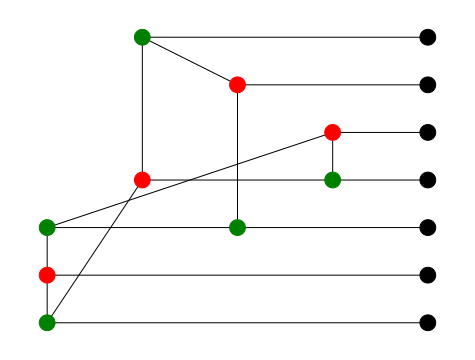

In [100]:
import networkx as nx


type_to_color = {
    zx.VertexType.Z: "green",
    zx.VertexType.X: "red",
    zx.VertexType.BOUNDARY: "black",
}


def zx_diagram_to_networkx_graph(graph):
    graph_dict = graph.to_dict()
    G = nx.Graph()
    pos = {}
    node_types = {}
    for v_data in graph_dict['vertices']:
        G.add_node(v_data['id'])
        (x, y) = v_data['pos']
        pos[v_data['id']] = (x, -y)
        node_types[v_data['id']] = v_data['t']
    for u, v, _ in graph_dict['edges']:
        G.add_edge(u, v)
    return G, pos, node_types


N = 7
G, pos, node_types = zx_diagram_to_networkx_graph(g)
node_colors = [type_to_color[node_types[n]] for n in G.nodes()]
boundaries = [n for n in G.nodes() if node_types[n] == zx.VertexType.BOUNDARY]
nx.draw(G, pos, node_color=node_colors, font_color='white', node_size=250)

In [101]:
import networkx as nx
from collections import deque
from functools import lru_cache
import time

def _feasibility_check_min_cost(G, anchors_available, remaining_paths, used_nodes):
    """
    Feasibility check using min-cost flow (network_simplex).
    Returns True iff it's possible to route `remaining_paths` anchor->anchor
    vertex-disjoint paths that cover EVERY remaining non-anchor exactly once.

    Only considers nodes in `G` that are not in used_nodes. Anchors_available is
    the subset of anchors that remain unused and may serve as endpoints.
    """
    # Build list of remaining nodes
    nodes_rem = [n for n in G.nodes() if n not in used_nodes]
    node_set = set(nodes_rem)
    # Count remaining non-anchors
    anchors_avail_set = set(anchors_available) & node_set
    non_anchors_rem = [n for n in nodes_rem if n not in anchors_avail_set]
    cnt_nonanchors = len(non_anchors_rem)

    # Quick necessary feasibility checks
    if remaining_paths < 0:
        return False
    if 2 * remaining_paths > len(anchors_avail_set):
        return False
    # If no non-anchors remain, we just need remaining_paths paths between anchors.
    # But we still need to check connectivity constraints; the flow check will cover that.

    # Build directed flow network with node-splitting
    DG = nx.DiGraph()
    S = ("__S__",)
    T = ("__T__",)
    DG.add_node(S, demand=-remaining_paths)
    DG.add_node(T, demand=remaining_paths)

    # Add vin->vout with capacity 1, weight = -1 for non-anchors, 0 for anchors
    for v in nodes_rem:
        vin = (v, "in")
        vout = (v, "out")
        DG.add_node(vin, demand=0)
        DG.add_node(vout, demand=0)
        cost = -1 if v not in anchors_avail_set else 0
        DG.add_edge(vin, vout, capacity=1, weight=cost)

    # Add edges for each undirected edge u--v in G if both endpoints remain
    for u, v in G.edges():
        if u in node_set and v in node_set:
            DG.add_edge((u, "out"), (v, "in"), capacity=1, weight=0)
            DG.add_edge((v, "out"), (u, "in"), capacity=1, weight=0)

    # Connect S -> anchor_out for available anchors (start options)
    for a in anchors_avail_set:
        DG.add_edge(S, (a, "out"), capacity=1, weight=0)
    # Connect anchor_in -> T for available anchors (end options)
    for a in anchors_avail_set:
        DG.add_edge((a, "in"), T, capacity=1, weight=0)

    # Solve min-cost flow
    try:
        total_cost, flow_dict = nx.network_simplex(DG)
    except Exception:
        # If solver fails for some reason, treat as infeasible
        return False

    # Check that we routed remaining_paths units
    flow_from_S = sum(flow_dict.get(S, {}).values())
    if flow_from_S != remaining_paths:
        return False

    # Each used non-anchor contributes -1 to total_cost via vin->vout
    expected_cost = -cnt_nonanchors
    return total_cost == expected_cost


def construct_anchor_paths(G, anchors, num_sources, timeout_seconds=30):
    """
    Construct exactly `num_sources` vertex-disjoint paths, each starting at an anchor
    and ending at another anchor, such that every non-anchor vertex is covered exactly once,
    and each anchor is used at most once (0 or 1 times).

    Strategy: build paths one-by-one (DFS), and after each path commitment run a
    feasibility check (min-cost flow) on the remaining graph. Use memoization to
    avoid repeated checks of identical (used_nodes, anchors_available, remaining_paths) states.

    Parameters
    ----------
    G : nx.Graph
    anchors : iterable of nodes (subset of G.nodes)
    num_sources : int
    timeout_seconds : int or float
        Abort search if exceeded (raises RuntimeError).

    Returns
    -------
    list of paths (each a list of nodes)
    Raises
    ------
    ValueError if no feasible cover exists.
    """
    anchors = list(dict.fromkeys(anchors))  # preserve order, unique
    node_set = set(G.nodes())
    if not set(anchors).issubset(node_set):
        raise ValueError("Some anchors are not nodes of G.")
    anchors_all = list(anchors)
    non_anchors_all = [n for n in G.nodes() if n not in anchors_all]

    # Basic feasibility check
    if 2 * num_sources > len(anchors_all):
        raise ValueError("Not enough anchors to form the requested number of anchor-anchor paths.")

    # Precompute adjacency for speed
    adj = {u: set(G.neighbors(u)) for u in G.nodes()}

    start_time = time.time()

    # memoization for infeasible states
    infeasible_cache = set()

    def state_key(used_nodes, anchors_avail, rem_paths):
        # frozen sets to build a hashable key
        return (frozenset(used_nodes), frozenset(anchors_avail), rem_paths)

    # generator: yield simple anchor->anchor paths starting at `start_anchor` given used_nodes
    def gen_paths_from(start_anchor, used_nodes_local, anchors_avail_local):
        """
        DFS enumerator for simple paths starting at 'start_anchor' and ending at an unused anchor.
        Internal nodes cannot be anchors (only endpoints are anchors).
        Does not enter nodes in used_nodes_local.
        """
        visited = {start_anchor}

        def dfs(cur, path):
            # time check
            if time.time() - start_time > timeout_seconds:
                raise RuntimeError("Timeout exceeded in search.")

            for nb in adj[cur]:
                if nb in visited or nb in used_nodes_local:
                    continue
                # If nb is an anchor:
                if nb in anchors_avail_local:
                    if nb != start_anchor:
                        yield path + [nb]
                    # do not go through anchor as internal node
                    continue
                # nb is non-anchor and unused; proceed
                visited.add(nb)
                yield from dfs(nb, path + [nb])
                visited.remove(nb)

        yield from dfs(start_anchor, [start_anchor])

    # Main backtracking
    def backtrack(paths_so_far, used_nodes_local, anchors_avail_local):
        # timeout
        if time.time() - start_time > timeout_seconds:
            raise RuntimeError("Timeout exceeded in search.")

        rem_paths = num_sources - len(paths_so_far)
        # if we've built all paths, check coverage of non-anchors
        if rem_paths == 0:
            # check all non-anchors used exactly once
            if set(non_anchors_all).issubset(used_nodes_local):
                return list(paths_so_far)
            else:
                return None

        # quick necessary check: enough anchors left to make rem_paths pairs
        if 2 * rem_paths > len(anchors_avail_local):
            return None

        # check memoized infeasibility
        key = state_key(used_nodes_local, anchors_avail_local, rem_paths)
        if key in infeasible_cache:
            return None

        # choose next start anchor deterministically: smallest index in anchors_all
        next_start = None
        for a in anchors_all:
            if a in anchors_avail_local:
                next_start = a
                break
        if next_start is None:
            return None

        # enumerate candidate paths starting at next_start
        try:
            path_iter = gen_paths_from(next_start, used_nodes_local, anchors_avail_local)
        except RuntimeError:
            raise
        found_any = False
        for path in path_iter:
            found_any = True
            end_anchor = path[-1]
            if end_anchor not in anchors_avail_local or end_anchor == next_start:
                continue
            # mark new used nodes and anchors
            new_used = used_nodes_local.union(path)
            new_anchors_avail = set(anchors_avail_local) - {next_start, end_anchor}

            # QUICK PRUNE: check feasibility of remaining problem
            if not _feasibility_check_min_cost(G, new_anchors_avail, rem_paths - 1, new_used):
                # record some pruning info? we rely on infeasible_cache below
                continue

            # recurse
            res = backtrack(paths_so_far + [path], new_used, new_anchors_avail)
            if res is not None:
                return res

        # If we tried all paths starting at next_start and none yielded success,
        # it might still be possible to skip using next_start as a start (use it later as endpoint).
        # Try to pick a later start anchor (to avoid symmetric permutations).
        idx = anchors_all.index(next_start)
        for later in anchors_all[idx+1:]:
            if later not in anchors_avail_local:
                continue
            # attempt to use 'later' as start instead, leaving next_start available
            # We try same enumeration for 'later'
            try:
                later_iter = gen_paths_from(later, used_nodes_local, anchors_avail_local)
            except RuntimeError:
                raise
            for path in later_iter:
                end_anchor = path[-1]
                if end_anchor not in anchors_avail_local or end_anchor == later:
                    continue
                new_used = used_nodes_local.union(path)
                new_anchors_avail = set(anchors_avail_local) - {later, end_anchor}
                if not _feasibility_check_min_cost(G, new_anchors_avail, rem_paths - 1, new_used):
                    continue
                res = backtrack(paths_so_far + [path], new_used, new_anchors_avail)
                if res is not None:
                    return res

        # no solution found from this state: memoize infeasible
        infeasible_cache.add(key)
        return None

    initial_used = set()
    anchors_avail_initial = set(anchors_all)
    result = backtrack([], initial_used, anchors_avail_initial)
    if result is None:
        raise ValueError("No feasible solution found.")
    return result


paths = construct_anchor_paths(G, boundaries, num_sources=3, timeout_seconds=20)
print("Found paths:", paths)

Found paths: [[23, 18, 17, 14, 29], [24, 19, 20, 16, 13, 28], [25, 21, 22, 26]]


In [117]:
import matplotlib.pyplot as plt
import networkx as nx
import itertools

def plot_path_cover(G, paths, anchors=None, pos=None, figsize=(8, 6),
                    node_size=300, anchor_node_size=600, with_labels=True,
                    edge_width=2.0, cmap="tab20", node_color=None):
    """
    Visualize a vertex-disjoint path cover on an undirected networkx Graph.

    Parameters
    ----------
    G : nx.Graph
        The graph (undirected).
    paths : list[list]
        List of paths (each a list of nodes in order) covering vertices of G.
    anchors : iterable or None
        Nodes to highlight as anchors (start/end). Best-effort: if an anchor
        isn't an endpoint, it will be circled anyway.
    pos : dict or None
        node -> (x,y) positions. If None, computed with nx.spring_layout(G).
        For stable drawings across runs, compute pos once and pass it back.
    figsize : tuple
        matplotlib figure size.
    node_size : int
        normal node size.
    anchor_node_size : int
        node size for anchors.
    with_labels : bool
        whether to draw node labels.
    edge_width : float
        width of path edges.
    cmap : str or matplotlib colormap
        colormap for path colors.
    """
    if pos is None:
        pos = nx.spring_layout(G, seed=42)

    # flatten nodes in paths to ensure we cover all nodes (some may be missing)
    covered = set(itertools.chain.from_iterable(paths))
    all_nodes = list(G.nodes())

    # prepare colors
    num_paths = max(1, len(paths))
    cmap_obj = plt.get_cmap(cmap)
    colors = [cmap_obj(i % cmap_obj.N) for i in range(num_paths)]

    # build figure
    plt.figure(figsize=figsize)
    ax = plt.gca()
    ax.set_axis_off()

    # draw all edges faintly as background
    nx.draw_networkx_edges(G, pos, edgelist=[e for e in G.edges() if not any((e[0] in p and e[1] in p) or (e[1] in p and e[0] in p) for p in paths)],
                           alpha=0.15, width=1.0, edge_color="gray", ax=ax)

    # draw each path's edges and nodes
    for i, p in enumerate(paths):
        color = colors[i]
        # edges along the path (consecutive pairs)
        path_edges = [(p[j], p[j+1]) for j in range(len(p)-1)]
        # draw edges (ensure tuples are in the graph's edge orientation)
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, width=edge_width, edge_color=[color], ax=ax)
        # draw path nodes
        nx.draw_networkx_nodes(G, pos, nodelist=p, node_color=[color], node_size=node_size, ax=ax, edgecolors="k")

    # draw any uncovered nodes (should be none if paths cover all nodes)
    uncovered = [n for n in all_nodes if n not in covered]
    if uncovered:
        nx.draw_networkx_nodes(G, pos, nodelist=uncovered, node_color="lightgray", node_size=node_size, ax=ax, edgecolors="k")

    # anchors: highlight with a larger ring
    if anchors:
        anchors = set(anchors)
        anchors_in_graph = [a for a in anchors if a in G]
        if anchors_in_graph:
            nx.draw_networkx_nodes(G, pos, nodelist=anchors_in_graph, node_size=anchor_node_size,
                                   node_color="none", edgecolors="red", linewidths=2.0, ax=ax)
            # also re-draw anchor fill to make them stand out
            nx.draw_networkx_nodes(G, pos, nodelist=anchors_in_graph, node_size=node_size, node_color="white",
                                   edgecolors="red", linewidths=1.2, ax=ax)

    if with_labels:
        nx.draw_networkx_labels(G, pos, font_size=9, ax=ax)

    plt.tight_layout()
    return ax, pos


# 1) If you already have a networkx Graph `G` and computed paths:
paths = find_parallel_path_cover_terminal_paths(G, anchors=boundaries, num_sources=3)

ax, pos = plot_path_cover(G, paths, anchors=boundaries, pos=pos)
# Later re-use 'pos' to draw updated paths with identical node placement.

KeyboardInterrupt: 

In [118]:
h1 = set(range(16)) - {0, 1, 11, 12}
cnots =  [
    (10, 0), (0, 1), (7, 1), (3, 12), (6, 10), (8, 1), (4, 11), (11, 3), (13, 11), (9, 8), (14, 0), (10, 12), (3, 1), (5, 6), (0, 11), (6, 0), (7, 0), (1, 10), (11, 1), (9, 4), (2, 4), (4, 5),
]

circ = build_state_prep(h1, cnots)
zx.draw(circ)

In [119]:
g = circ.to_graph()
basic_reduce(g)
zx.draw(g, labels=True)

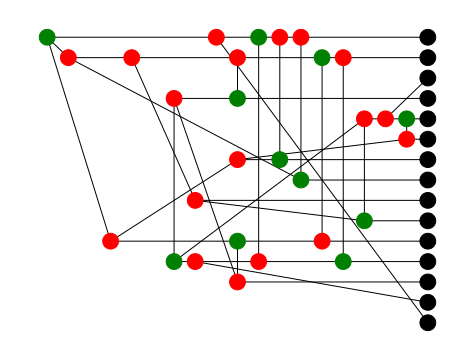

In [126]:
G, pos, node_types = zx_diagram_to_networkx_graph(g)
node_colors = [type_to_color[node_types[n]] for n in G.nodes()]
boundaries = {n for n in G.nodes() if node_types[n] == zx.VertexType.BOUNDARY}
z_spiders = {n for n in G.nodes() if node_types[n] == zx.VertexType.X}
x_spiders = {n for n in G.nodes() if node_types[n] == zx.VertexType.X}
nx.draw(G, pos, node_color=node_colors, font_color='white', node_size=250)

In [ ]:
def find_good_mc_flow(G: nx.Graph, anchors, z_spiders, x_spiders, min_paths):
    current_number_of_paths = 0
    while current_number_of_paths < min_paths:
        path = [anchors[0], next(G.neighbors(anchors[0]))]
        covered_vetices = set(path)
        path_nexts = [None, None]
        while path[-1] not in anchors:
            path_nexts.append(G.neighbors(path[-1]))
            pass
